Catboost - 90 day churn - sentiment

In [1]:
!pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [2]:
from tensorflow.python.client import device_lib

def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]

print(get_available_devices())

2022-11-10 01:48:52.732140: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-10 01:48:52.898555: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-10 01:48:53.573943: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/compat/lib.real:/opt/conda/lib/python3.8/site-packages/torch/lib:/opt/conda/lib/python3.8/site-packages/torch_tensorrt/lib:/usr/local/cuda/compat/lib:/usr/local/nvidia/lib:/usr/local/nvidia/lib64


['/device:CPU:0', '/device:GPU:0', '/device:GPU:1', '/device:GPU:2', '/device:GPU:3', '/device:GPU:4', '/device:GPU:5', '/device:GPU:6', '/device:GPU:7']


2022-11-10 01:48:54.499665: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-10 01:48:58.691837: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /device:GPU:0 with 37814 MB memory:  -> device: 0, name: A100-SXM4-40GB, pci bus id: 0000:07:00.0, compute capability: 8.0
2022-11-10 01:48:58.693917: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /device:GPU:1 with 37814 MB memory:  -> device: 1, name: A100-SXM4-40GB, pci bus id: 0000:0f:00.0, compute capability: 8.0
2022-11-10 01:48:58.695613: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /device:GPU:2 with 37814 MB memory:  -> device: 2, name: A100-SXM4-40GB, pci bus id: 0000:47:00.0, compute capab

In [3]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [4]:
import pandas as pd
import numpy as np
# import seaborn
import matplotlib.pyplot as plt
%matplotlib inline

import pickle
import joblib
import time

from catboost import CatBoostClassifier

import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBClassifier, plot_importance
from sklearn import config_context
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import cross_val_predict 
from sklearn.model_selection import cross_val_score 
from sklearn.feature_selection import RFECV
from sklearn.metrics import precision_score, f1_score, recall_score, confusion_matrix, accuracy_score, roc_auc_score

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 500)
pd.set_option('display.float_format', '{:.2f}'.format)

import warnings
warnings.filterwarnings('ignore')

!pip install ipywidgets
!pip install catboost
import ipywidgets
import catboost as cb
from catboost import CatBoostClassifier
from sklearn.metrics import auc, roc_auc_score, roc_curve

In [5]:
%cd ..

/workspace/asurion_f22


In [6]:
test = pd.read_csv('fe_data/90_day_churn_data/test_90d_encoded.csv')

In [7]:
sen_test = pd.read_csv('fe_data/sentiment_data/sentiment_test.csv')

In [8]:
len(sen_test)

218213

In [9]:
len(test)

19718

In [10]:
test.columns

Index(['id', 'quality_sale', 'ninety_day_churn', 'clndr_dt_cst', 'start_dt',
       'lines', 'previous_tech_support_call', 'account_tenure',
       'past_yr_claim_count', 'num_decline', 'exp', 'product_type', 'pmake',
       'claritas_hh_count', 'technodoption_class', 'hh_income', 'age_class',
       'hh_education', 'hh_composition', 'hh_tenure', 'urbanicity',
       'median_income', 'total_population', 'perc_female', 'perc_under18',
       'perc_over65', 'perc_white', 'perc_black', 'population_density',
       'zipcode', 'county', 'state', 'state_code', 'latitude', 'longitude',
       'month', 'hh_income_code', 'day_of_week', 'time_of_day',
       'zipcode_accepted_prop', 'zipcode_rejected_offers',
       'zipcode_accepted_offers', 'zipcode_total_offers'],
      dtype='object')

In [11]:
dcols = ['quality_sale', 'clndr_dt_cst', 'start_dt', 'zipcode', 'county', 'state', 
         'state_code', 'latitude', 'longitude', 'month','hh_income_code']

In [12]:
test.drop(columns = dcols, inplace = True)
test = test[(test['zipcode_accepted_prop'].isnull()==False)& (test['zipcode_rejected_offers'].isnull()==False)& 
            (test['zipcode_accepted_offers'].isnull()==False)&(test['zipcode_total_offers'].isnull()==False)]

In [13]:
len(sen_test)

218213

In [14]:
test = test.merge(sen_test, on='id', how='inner')

In [15]:
len(test)

12942

In [16]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12942 entries, 0 to 12941
Data columns (total 33 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          12942 non-null  object 
 1   ninety_day_churn            12942 non-null  float64
 2   lines                       12942 non-null  int64  
 3   previous_tech_support_call  12942 non-null  int64  
 4   account_tenure              12942 non-null  int64  
 5   past_yr_claim_count         12942 non-null  int64  
 6   num_decline                 12942 non-null  int64  
 7   exp                         12942 non-null  int64  
 8   product_type                12942 non-null  object 
 9   pmake                       12942 non-null  object 
 10  claritas_hh_count           12942 non-null  int64  
 11  technodoption_class         12942 non-null  object 
 12  hh_income                   12942 non-null  object 
 13  age_class                   129

In [17]:
train = pd.read_csv('fe_data/90_day_churn_data/train_90d_encoded.csv')

In [18]:
len(train)

85707

In [19]:
sen_train = pd.read_csv('fe_data/sentiment_data/sentiment_train.csv')

In [20]:
len(sen_train["id"].unique())

1044430

In [21]:
train = train.merge(sen_train, on='id', how='inner')

In [22]:
len(train)

72276

In [23]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 72276 entries, 0 to 72275
Data columns (total 44 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          72276 non-null  object 
 1   quality_sale                72276 non-null  int64  
 2   ninety_day_churn            72276 non-null  float64
 3   clndr_dt_cst                72276 non-null  object 
 4   start_dt                    72276 non-null  object 
 5   lines                       72276 non-null  int64  
 6   previous_tech_support_call  72276 non-null  int64  
 7   account_tenure              72276 non-null  int64  
 8   past_yr_claim_count         72276 non-null  int64  
 9   num_decline                 72276 non-null  int64  
 10  exp                         72276 non-null  int64  
 11  product_type                72276 non-null  object 
 12  pmake                       72276 non-null  object 
 13  claritas_hh_count           722

In [24]:
train.head()

,id,quality_sale,ninety_day_churn,clndr_dt_cst,start_dt,lines,previous_tech_support_call,account_tenure,past_yr_claim_count,num_decline,exp,product_type,pmake,claritas_hh_count,technodoption_class,hh_income,age_class,hh_education,hh_composition,hh_tenure,urbanicity,median_income,total_population,perc_female,perc_under18,perc_over65,perc_white,perc_black,population_density,zipcode,county,state,state_code,latitude,longitude,month,hh_income_code,day_of_week,time_of_day,zipcode_accepted_prop,zipcode_rejected_offers,zipcode_accepted_offers,zipcode_total_offers,sentiment
0,68943556bf63277816d843ffb129e23ffe60bc5b982603...,1,0.00,2022-03-01 00:00:00.000,2022-03-01 12:22:15.780,2,4,689,1,8,1,SD,android,1715961,High-Tech,4 Midscale,1 Younger,3 Some College,1 w/ Kids,5 Renters,7 Metro Mix,49842,34512,48,27,9,74,11,1894,77301.00,Conroe,Texas,TX,30.31,-95.45,march,4,Tuesday,12,0.19,57.00,13.00,70.00,positive
1,6c09cf1d3246c800ba864c7eaced4b1e7a38b09f90ebc3...,1,0.00,2022-03-17 00:00:00.000,2022-03-17 15:29:30.018,2,1,72,0,0,1,SD,android,3161699,Mid-Tech,4 Midscale,1 Younger,3 Some College,5 w/o Kids,4 Mostly Renters,7 Metro Mix,71662,41592,50,12,17,84,1,5533,85251.00,Scottsdale,Arizona,AZ,33.49,-111.92,march,4,Thursday,15,0.09,125.00,12.00,137.00,positive
2,5221cde1976fcd8a4d0d6fb059e04ed6d9b6450b68020d...,1,0.00,2022-03-07 00:00:00.000,2022-03-07 09:11:47.002,2,1,237,0,0,1,SD,android,2444705,Mid-Tech,2 Upscale,3 Older,1 Graduate Plus,5 w/o Kids,2 Mostly Owners,8 Mix,73514,41147,47,21,13,58,4,4466,7032.00,Kearny,New Jersey,NJ,40.76,-74.15,march,2,Monday,9,0.13,90.00,13.00,103.00,neutral
3,a68e921aeb079a7c79de714f566802dedde074721d40a4...,0,1.00,2022-03-04 00:00:00.000,2022-03-04 15:00:09.566,2,2,3062,2,0,1,SD,android,0,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,35982,485,39,0,48,99,0,8,3812.00,Bartlett,New Hampshire,NH,44.08,-71.29,march,8,Friday,15,0.00,1.00,0.00,1.00,negative
4,b9b75e5295e70045ba4f1c4d0b5de77b6e03df31f200bc...,1,0.00,2022-03-04 00:00:00.000,2022-03-04 11:56:31.079,1,2,2585,0,1,1,SD,android,2843065,Low-Tech,3 Upper Midscale,4 Mature,1 Graduate Plus,5 w/o Kids,2 Mostly Owners,8 Mix,89029,34659,52,17,21,81,1,4462,92672.00,San Clemente,California,CA,33.44,-117.62,march,3,Friday,11,0.08,129.00,11.00,140.00,negative


In [25]:
len(train)

72276

In [26]:
train.drop(columns = dcols, inplace = True)
train = train[(train['zipcode_accepted_prop'].isnull()==False)& (train['zipcode_rejected_offers'].isnull()==False)& 
            (train['zipcode_accepted_offers'].isnull()==False)&(train['zipcode_total_offers'].isnull()==False)]

In [27]:
len(train)

71103

In [28]:
train.columns

Index(['id', 'ninety_day_churn', 'lines', 'previous_tech_support_call',
       'account_tenure', 'past_yr_claim_count', 'num_decline', 'exp',
       'product_type', 'pmake', 'claritas_hh_count', 'technodoption_class',
       'hh_income', 'age_class', 'hh_education', 'hh_composition', 'hh_tenure',
       'urbanicity', 'median_income', 'total_population', 'perc_female',
       'perc_under18', 'perc_over65', 'perc_white', 'perc_black',
       'population_density', 'day_of_week', 'time_of_day',
       'zipcode_accepted_prop', 'zipcode_rejected_offers',
       'zipcode_accepted_offers', 'zipcode_total_offers', 'sentiment'],
      dtype='object')

In [29]:
test.columns

Index(['id', 'ninety_day_churn', 'lines', 'previous_tech_support_call',
       'account_tenure', 'past_yr_claim_count', 'num_decline', 'exp',
       'product_type', 'pmake', 'claritas_hh_count', 'technodoption_class',
       'hh_income', 'age_class', 'hh_education', 'hh_composition', 'hh_tenure',
       'urbanicity', 'median_income', 'total_population', 'perc_female',
       'perc_under18', 'perc_over65', 'perc_white', 'perc_black',
       'population_density', 'day_of_week', 'time_of_day',
       'zipcode_accepted_prop', 'zipcode_rejected_offers',
       'zipcode_accepted_offers', 'zipcode_total_offers', 'sentiment'],
      dtype='object')

In [30]:
def transform_xy(dat):
    X_ori = dat[[
#         'emplid','cvp_call_id',
                 'lines', 'previous_tech_support_call','account_tenure', 'past_yr_claim_count', 
                'num_decline', 'exp', 
#                  'churn',
                 'product_type', 'pmake', 
                 'claritas_hh_count',
                 'technodoption_class', 'hh_income', 'age_class', 'hh_education',
                 'hh_composition', 'hh_tenure', 'urbanicity','median_income', 'total_population', 
                 'perc_female', 'perc_under18',
                'perc_over65', 'perc_white', 'perc_black', 'population_density', 'day_of_week', 'time_of_day',
       'zipcode_accepted_prop', 'zipcode_rejected_offers',
       'zipcode_accepted_offers', 'zipcode_total_offers', 'sentiment']]
    y = dat[['ninety_day_churn']]
   
    X_ori.loc[X_ori.lines.isnull(), 'lines'] = 0
    X_ori.exp = X_ori.exp.apply(int)
    X_ori.num_decline = X_ori.num_decline.apply(float)
    X_ori.loc[X_ori.account_tenure.isnull(), 'account_tenure'] = 0
    X_ori.loc[X_ori.claritas_hh_count.isnull(), 'claritas_hh_count'] = 0
    X_ori.loc[X_ori.exp.isnull(), 'exp'] = 'Unknown'
    X_ori.loc[X_ori.product_type.isnull(), 'product_type'] = 'Unknown'
    X_ori.loc[X_ori.pmake.isnull(), 'pmake'] = 'Unknown'
    X_ori.loc[X_ori.technodoption_class.isnull(), 'technodoption_class'] = 'Unknown'
    X_ori.loc[X_ori.hh_income.isnull(), 'hh_income'] = 'Unknown'
    X_ori.loc[X_ori.age_class.isnull(), 'age_class'] = 'Unknown'
    X_ori.loc[X_ori.hh_education.isnull(), 'hh_education'] = 'Unknown'
    X_ori.loc[X_ori.hh_composition.isnull(), 'hh_composition'] = 'Unknown'
    X_ori.loc[X_ori.hh_tenure.isnull(), 'hh_tenure'] = 'Unknown'
    X_ori.loc[X_ori.urbanicity.isnull(), 'urbanicity'] = 'Unknown'
    X_ori.loc[X_ori.day_of_week.isnull(), 'day_of_week'] = 'Unknown'
    X_ori.loc[X_ori.time_of_day.isnull(), 'time_of_day'] = 'Unknown'
    X_ori.loc[X_ori.zipcode_accepted_prop.isnull(), 'zipcode_accepted_prop'] = 0
    X_ori.loc[X_ori.zipcode_rejected_offers.isnull(), 'zipcode_rejected_offers'] = 0
    X_ori.loc[X_ori.zipcode_accepted_offers.isnull(), 'zipcode_accepted_offers'] = 0
    X_ori.loc[X_ori.zipcode_total_offers.isnull(), 'zipcode_total_offers'] = 0
    X_ori.loc[X_ori.sentiment.isnull(), 'sentiment'] = "Unknown"

    return X_ori,y

In [31]:
X,y = transform_xy(train)
x_hold_out, y_hold_out = transform_xy(test)

In [32]:
X['lines'] = X['lines'].astype(np.int) 
X['previous_tech_support_call'] = X['previous_tech_support_call'].astype('category')
X['num_decline'] = X['num_decline'].astype(np.int) 
X['past_yr_claim_count'] = X['past_yr_claim_count'].astype(np.int) 
X['exp'] = X['exp'].astype('category') 
X['account_tenure'] = X['account_tenure'].astype(np.int) 
X['pmake'] = X['pmake'].astype('category')
X['technodoption_class'] = X['technodoption_class'].astype('category')
X['claritas_hh_count'] = X['claritas_hh_count'].astype('category')
X['hh_income'] = X['hh_income'].astype('category')
X['age_class'] = X['age_class'].astype('category')
X['hh_education'] = X['hh_education'].astype('category')
X['hh_composition'] = X['hh_composition'].astype('category')
X['hh_tenure'] = X['hh_tenure'].astype('category')
X['urbanicity'] = X['urbanicity'].astype('category')
X['product_type'] = X['product_type'].astype('category')
X['day_of_week'] = X['day_of_week'].astype('category')
X['time_of_day'] = X['time_of_day'].astype('category')
X['zipcode_accepted_prop'] = (X['zipcode_accepted_prop']*100).astype(np.int)
X['zipcode_rejected_offers'] = X['zipcode_rejected_offers'].astype(np.int)
X['zipcode_accepted_offers'] = X['zipcode_accepted_offers'].astype(np.int)
X['zipcode_total_offers'] = X['zipcode_total_offers'].astype(np.int)
X['sentiment'] = X['sentiment'].astype('category')


X['median_income'] = X['median_income'].astype(np.int)
X['total_population'] = X['total_population'].astype(np.int)
X['perc_female'] = X['perc_female'].astype(np.int)
X['perc_under18'] = X['perc_under18'].astype(np.int)
X['perc_over65'] = X['perc_over65'].astype(np.int)
X['perc_white'] = X['perc_white'].astype(np.int)
X['perc_black'] = X['perc_black'].astype(np.int)
X['population_density'] = X['population_density'].astype(np.int)

In [33]:
x_hold_out['lines'] = x_hold_out['lines'].astype(np.int) 
x_hold_out['previous_tech_support_call'] = x_hold_out['previous_tech_support_call'].astype('category')
x_hold_out['num_decline'] = x_hold_out['num_decline'].astype(np.int) 
x_hold_out['past_yr_claim_count'] = x_hold_out['past_yr_claim_count'].astype(np.int) 
x_hold_out['exp'] = x_hold_out['exp'].astype('category') 
x_hold_out['account_tenure'] = x_hold_out['account_tenure'].astype(np.int) 
x_hold_out['pmake'] = x_hold_out['pmake'].astype('category')
x_hold_out['technodoption_class'] = x_hold_out['technodoption_class'].astype('category')
x_hold_out['claritas_hh_count'] = x_hold_out['claritas_hh_count'].astype('category')
x_hold_out['hh_income'] = x_hold_out['hh_income'].astype('category')
x_hold_out['age_class'] = x_hold_out['age_class'].astype('category')
x_hold_out['hh_education'] = x_hold_out['hh_education'].astype('category')
x_hold_out['hh_composition'] = x_hold_out['hh_composition'].astype('category')
x_hold_out['hh_tenure'] = x_hold_out['hh_tenure'].astype('category')
x_hold_out['urbanicity'] = x_hold_out['urbanicity'].astype('category')
x_hold_out['product_type'] = x_hold_out['product_type'].astype('category')
x_hold_out['day_of_week'] = x_hold_out['day_of_week'].astype('category')
x_hold_out['time_of_day'] = x_hold_out['time_of_day'].astype('category')
x_hold_out['zipcode_accepted_prop'] = (x_hold_out['zipcode_accepted_prop']*100).astype(np.int)
x_hold_out['zipcode_rejected_offers'] = x_hold_out['zipcode_rejected_offers'].astype(np.int)
x_hold_out['zipcode_accepted_offers'] = x_hold_out['zipcode_accepted_offers'].astype(np.int)
x_hold_out['zipcode_total_offers'] = x_hold_out['zipcode_total_offers'].astype(np.int)
x_hold_out['sentiment'] = x_hold_out['sentiment'].astype('category')


x_hold_out['median_income'] = x_hold_out['median_income'].astype(np.int)
x_hold_out['total_population'] = x_hold_out['total_population'].astype(np.int)
x_hold_out['perc_female'] = x_hold_out['perc_female'].astype(np.int)
x_hold_out['perc_under18'] = x_hold_out['perc_under18'].astype(np.int)
x_hold_out['perc_over65'] = x_hold_out['perc_over65'].astype(np.int)
x_hold_out['perc_white'] = x_hold_out['perc_white'].astype(np.int)
x_hold_out['perc_black'] = x_hold_out['perc_black'].astype(np.int)
x_hold_out['population_density'] = x_hold_out['population_density'].astype(np.int)

In [34]:
len(x_hold_out)

12942

In [35]:
len(X)

71103

In [36]:
len(y)

71103

In [37]:
type(train)

pandas.core.frame.DataFrame

In [38]:
type(test)

pandas.core.frame.DataFrame

In [39]:
len(test)

12942

In [40]:
len(x_hold_out)

12942

In [41]:
len(y_hold_out)

12942

In [42]:
Xf_train, Xf_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, stratify=y['ninety_day_churn'])

In [56]:
Xf_train.columns

Index(['lines', 'previous_tech_support_call', 'account_tenure',
       'past_yr_claim_count', 'num_decline', 'exp', 'product_type', 'pmake',
       'claritas_hh_count', 'technodoption_class', 'hh_income', 'age_class',
       'hh_education', 'hh_composition', 'hh_tenure', 'urbanicity',
       'median_income', 'total_population', 'perc_female', 'perc_under18',
       'perc_over65', 'perc_white', 'perc_black', 'population_density',
       'day_of_week', 'time_of_day', 'zipcode_accepted_prop',
       'zipcode_rejected_offers', 'zipcode_accepted_offers',
       'zipcode_total_offers', 'sentiment'],
      dtype='object')

In [57]:
Xf_test.columns

Index(['lines', 'previous_tech_support_call', 'account_tenure',
       'past_yr_claim_count', 'num_decline', 'exp', 'product_type', 'pmake',
       'claritas_hh_count', 'technodoption_class', 'hh_income', 'age_class',
       'hh_education', 'hh_composition', 'hh_tenure', 'urbanicity',
       'median_income', 'total_population', 'perc_female', 'perc_under18',
       'perc_over65', 'perc_white', 'perc_black', 'population_density',
       'day_of_week', 'time_of_day', 'zipcode_accepted_prop',
       'zipcode_rejected_offers', 'zipcode_accepted_offers',
       'zipcode_total_offers', 'sentiment'],
      dtype='object')

In [44]:
train_census_dataset = cb.Pool(Xf_train,y_train, 
                        cat_features=np.where(Xf_train.dtypes != np.int)[0])                                                      
test_census_dataset = cb.Pool(Xf_test, y_test,           
                       cat_features=np.where(Xf_test.dtypes != np.int)[0])

In [45]:
holdout_census_dataset = cb.Pool(x_hold_out, y_hold_out,           
                       cat_features=np.where(x_hold_out.dtypes != np.int)[0])

In [46]:
spw = (y_train['ninety_day_churn'] == 0.00).sum()/(y_train['ninety_day_churn'] == 1.00).sum()
spw

2.3819392539240334

In [47]:
from catboost import CatBoostClassifier

In [49]:
#initiate model
cat_model_census = CatBoostClassifier(
    cat_features = np.where(Xf_train.dtypes != np.int)[0],
    scale_pos_weight=spw,
    max_depth = 5,
    learning_rate = 0.05
)
#train
cat_model_census.fit(train_census_dataset, 
       eval_set=test_census_dataset,
      plot=True, silent= True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [50]:
pred_census = cat_model_census.predict_proba(holdout_census_dataset)
threshold=0.5
predicted_cat_census = (pred_census[:,1] >= threshold).astype('int')
tn, fp, fn, tp = confusion_matrix(y_hold_out, predicted_cat_census).ravel()
print("catboost_holdoutset",'\n',
    "recall:",recall_score(y_hold_out, predicted_cat_census),'\n',
     'precision',precision_score(y_hold_out, predicted_cat_census),'\n',
     confusion_matrix(y_hold_out, predicted_cat_census),'\n',
     'f1 score:',f1_score(y_hold_out, predicted_cat_census),'\n',
     'tn:{}, fp:{}, fn:{}, tp:{}'.format(tn, fp, fn, tp),'\n')

catboost_holdoutset 
 recall: 0.4230203120400353 
 precision 0.32183650615901455 
 [[6517 3028]
 [1960 1437]] 
 f1 score: 0.3655558382091071 
 tn:6517, fp:3028, fn:1960, tp:1437 



In [51]:
pred_census = cat_model_census.predict_proba(test_census_dataset)
threshold=0.5
predicted_cat_census = (pred_census[:,1] >= threshold).astype('int')
tn, fp, fn, tp = confusion_matrix(y_test, predicted_cat_census).ravel()
print("catboost_testset",'\n',
    "recall:",recall_score(y_test, predicted_cat_census),'\n',
     'precision',precision_score(y_test, predicted_cat_census),'\n',
     confusion_matrix(y_test, predicted_cat_census),'\n',
     'f1 score:',f1_score(y_test, predicted_cat_census),'\n',
     'tn:{}, fp:{}, fn:{}, tp:{}'.format(tn, fp, fn, tp),'\n')

catboost_testset 
 recall: 0.5012682308180089 
 precision 0.4394107837687604 
 [[10989  4034]
 [ 3146  3162]] 
 f1 score: 0.46830568720379145 
 tn:10989, fp:4034, fn:3146, tp:3162 



In [52]:
vip = cat_model_census.feature_importances_

#create df with vip info
feature_importances_info = pd.DataFrame({'feat_names':Xf_train.columns, 'vip': vip})

#get sign and magnitude information
feature_importances_info = feature_importances_info.assign(feature_importances_mag = abs(feature_importances_info['vip']),
                             feature_importances_sign = np.sign(feature_importances_info['vip']))
feature_importances_info = feature_importances_info.set_index('feat_names').sort_values(by='feature_importances_mag', ascending=False)
feature_importances_info.head(15)

,vip,feature_importances_mag,feature_importances_sign
feat_names,,,
lines,14.79,14.79,1.00
account_tenure,7.77,7.77,1.00
zipcode_accepted_offers,7.66,7.66,1.00
zipcode_accepted_prop,7.17,7.17,1.00
median_income,5.67,5.67,1.00
previous_tech_support_call,4.19,4.19,1.00
population_density,4.18,4.18,1.00
total_population,3.61,3.61,1.00
perc_white,3.61,3.61,1.00


In [53]:
!pip install seaborn

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


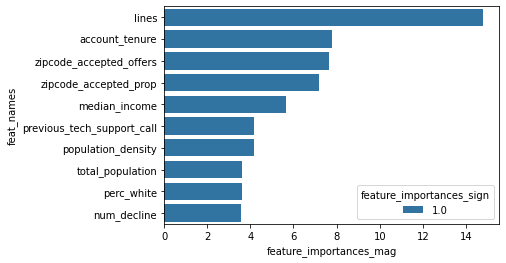

In [54]:
import seaborn as sns
sns.barplot(y=feature_importances_info.index[:10], x='feature_importances_mag', hue='feature_importances_sign', 
            data=feature_importances_info[:10], orient='h', dodge=False);

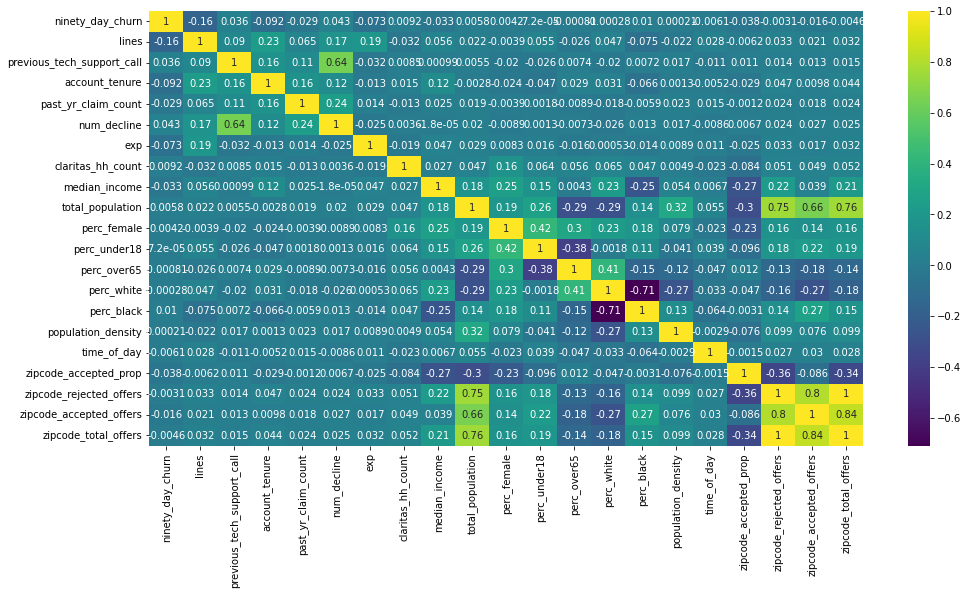

In [55]:
plt.figure(figsize = (16,8))
cor = train.corr()
sns.heatmap(cor, annot = True, cmap = "viridis")
plt.show()